In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gustavoachavez/architectural-styles-periods-dataset")

print("Path to dataset files:", path)
# import everything ml
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import re
import string
from wordcloud import WordCloud
import nltk
from collections import Counter
import contractions
from tqdm import tqdm
import math
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from PIL import Image, ImageFile
from torch.utils.data import ConcatDataset
from PIL import ImageDraw
import datasets
from datasets import load_dataset

Path to dataset files: /home/software/.cache/kagglehub/datasets/gustavoachavez/architectural-styles-periods-dataset/versions/1


In [34]:
class CNNClassifier(nn.Module):
    def __init__(self, out_channels):
        super(CNNClassifier, self).__init__()

        def conv_block(out_channels):
            return nn.Sequential(
                nn.LazyConv2d(out_channels, kernel_size=3),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.LazyBatchNorm2d()
            )
        
        def linear_block(out_channels):
            return nn.Sequential(
                nn.Dropout(p=0.3),
                nn.LazyLinear(out_channels),
                nn.ReLU(),
                
            )

        self.conv1 = conv_block(64)
        self.conv2 = conv_block(128)
        self.conv3 = conv_block(256)

        self.conv4 = conv_block(256)
        self.conv5 = conv_block(256)

        self.fc1 = linear_block(256)
        self.fc2 = linear_block(128)
        self.fc3 = nn.Linear(128,out_channels)
    def forward(self, x):
        #print("before conv1")
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = torch.concat((self.conv4(x), self.conv5(x)), dim=1)[:, :self.conv4(x).shape[1]] 
        x = self.conv5(x)
        #print("before flatten")
        x = x.view(x.size(0), -1)
        #print("after flatten")
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        #print("linear done")
        return x


In [35]:
# prompt: write me a script that classifies buildings into architectural styles based on the training data downloaded in the above cell pytorch

import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os
import shutil
import time
import copy

# Download latest version
path = kagglehub.dataset_download("gustavoachavez/architectural-styles-periods-dataset")
print("Path to dataset files:", path)

# Define the path to the downloaded dataset
# Adjust the dataset_path to point to the directory containing the style subdirectories
dataset_path = os.path.join(path, 'Capstone_Architectural_Styles_dataset')


# Define transforms for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# The dataset structure downloaded by kagglehub might need restructuring
# to be compatible with ImageFolder. It's usually structured as
# dataset_path/dataset-card.json, dataset_path/images/style1/img1.jpg, etc.
# We need to ensure the structure is dataset_path/style1/img1.jpg for ImageFolder.

# Let's assume the images are in a subdirectory like 'images' within the downloaded path.
# We'll move the style directories from the 'images' subdirectory up to the main dataset_path.
# If the structure is already flat (dataset_path/style1/img1.jpg), you can skip this.

source_images_dir = os.path.join(path, 'images') # Adjust 'images' if needed
if os.path.exists(source_images_dir):
  print(f"Restructuring dataset from {source_images_dir}...")
  style_dirs = [d for d in os.listdir(source_images_dir) if os.path.isdir(os.path.join(source_images_dir, d))]
  for style_dir in style_dirs:
    shutil.move(os.path.join(source_images_dir, style_dir), dataset_path)
  shutil.rmtree(source_images_dir)
  print("Dataset restructured.")
else:
  print(f"'{source_images_dir}' not found. Assuming dataset is already structured for ImageFolder.")

# subdirs = [os.path.join(dataset_path, d) for d in os.listdir(dataset_path) 
#            if os.path.isdir(os.path.join(dataset_path, d))]
# all_subdatasets = [ImageFolder(subdir) for subdir in subdirs]
# full_dataset = ConcatDataset(all_subdatasets)

# Flatten any nested subfolders so that dataset_path contains style folders directly

for sub in os.listdir(dataset_path):
    sub_path = os.path.join(dataset_path, sub)
    if os.path.isdir(sub_path):
        for style in os.listdir(sub_path):
            style_path = os.path.join(sub_path, style)
            target_path = os.path.join(dataset_path, style)
            if os.path.isdir(style_path) and not os.path.exists(target_path):
                shutil.move(style_path, dataset_path)
        shutil.rmtree(sub_path)  # Remove the now-empty subfolder

print("Dataset structure flattened")

full_dataset = ImageFolder(dataset_path)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Found {num_classes} architectural styles: {class_names}")
# Load the datasets using ImageFolder
# full_dataset = datasets.ImageFolder(dataset_path)

# Get the class names (architectural styles)
# class_names = full_dataset.classes
# num_classes = len(class_names)
# print(f"Found {num_classes} architectural styles: {class_names}")
# class_names = [all_subdatasets[i].classes for i,_ in enumerate(all_subdatasets)]
class_names = [cls for dataset in all_subdatasets for cls in dataset.classes]
num_classes = len(class_names)
print(f"Found {num_classes} architectural styles: {[all_subdatasets[i].classes for i,_ in enumerate(all_subdatasets)]}")

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Apply the transforms to the split datasets
# Note: random_split gives Subset objects, which don't have a transform attribute.
# We need to create new datasets that apply the transforms.
# A custom dataset class could be more robust, but this is a simple approach for illustration.

class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

train_dataset_transformed = TransformedDataset(train_dataset, transform=data_transforms['train'])
val_dataset_transformed = TransformedDataset(val_dataset, transform=data_transforms['val'])
test_dataset_transformed = TransformedDataset(test_dataset, transform=data_transforms['test'])

# Create DataLoaders
train_loader = DataLoader(train_dataset_transformed, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset_transformed, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset_transformed, batch_size=64, shuffle=False, num_workers=8)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load a pretrained model (e.g., ResNet18)
# model = models.resnet18(weights='DEFAULT') # Use weights='DEFAULT' for latest recommended weights

# # Replace the classifier layer
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
model = CNNClassifier(out_channels=num_classes)
# Dummy input for initialization (e.g., batch of size 1 with 3 channels, 64x64 image)
dummy_input = torch.randn(1, 3,224, 224)
_ = model(dummy_input)  # triggers lazy module initialization

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Standard PyTorch Training Loop ---

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model if it has better validation accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
print("Starting training...")
model_ft = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=30)
print("Training finished.")


# --- Standard PyTorch Testing ---

def test_model(model, criterion, test_loader):
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')

# Test the model
print("Starting testing...")
test_model(model_ft, criterion, test_loader)
print("Testing finished.")


# You can now use the trained model for inference on new images.
# For example, to predict the style of a single image:
# Load and preprocess a new image
# image_path = "path/to/your/new_image.jpg"
# from PIL import Image
# image = Image.open(image_path).convert('RGB')
# image_tensor = data_transforms['val'](image).unsqueeze(0) # Add batch dimension
#
# # Make prediction
# model_ft.eval()
# with torch.no_grad():
#     outputs = model_ft(image_tensor.to(device)) # Move image tensor to device
#     _, predicted_class_index = torch.max(outputs, 1)
# predicted_style = class_names[predicted_class_index.item()]
# print(f"Predicted architectural style: {predicted_style}")

Path to dataset files: /home/software/.cache/kagglehub/datasets/gustavoachavez/architectural-styles-periods-dataset/versions/1
'/home/software/.cache/kagglehub/datasets/gustavoachavez/architectural-styles-periods-dataset/versions/1/images' not found. Assuming dataset is already structured for ImageFolder.
Dataset structure flattened
Found 45 architectural styles: ['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Andean Baroque Architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Blobitecture', 'Brutalism', 'Byzantine architecture', 'Chicago school architecture', 'Colonial Revival archtecture', 'Colonial architecture', 'Deconstructivism', 'Earthquake Baroque Architecture', 'Eco-architecture', 'Edwardian architecture', 'French Renaissance Architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architec

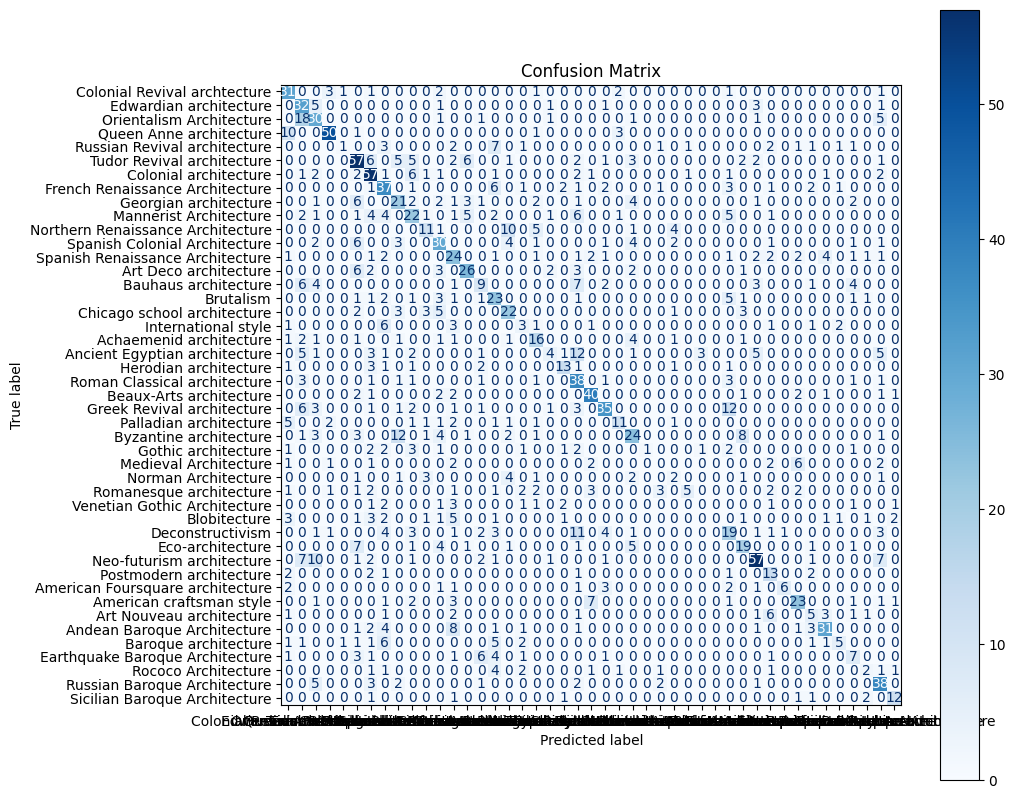

In [36]:
# ... existing code ...

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming attr: dataloaders['val'] exists - your validation dataloader
true_labels = []
predicted_labels = []

model_ft.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,10))  # Adjust size as needed
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Classifying random image: /home/software/.cache/kagglehub/datasets/gustavoachavez/architectural-styles-periods-dataset/versions/1/Capstone_Architectural_Styles_dataset/Romanesque architecture/34260.jpg
Randomly selected image:


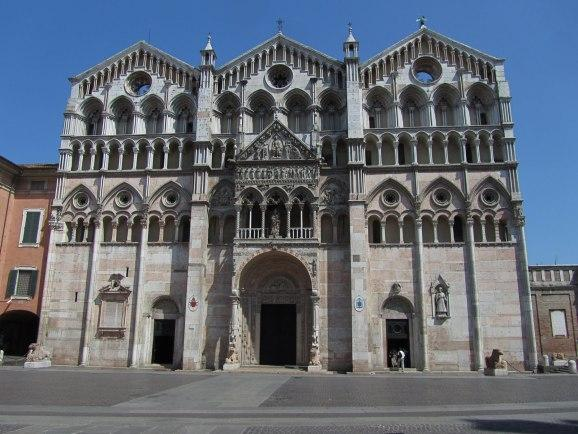

tensor([[ -2.6580, -11.2237, -10.7362, -10.0915,  -7.5324,  -2.8632,   1.5515,
          -5.0160,  -4.6416,  -0.3981, -12.5885,  -9.7628,   7.4354,  -9.7614,
         -10.1708,  -3.5885, -13.1045,  -3.5779,  -6.3789,  -6.9464,  -1.2162,
          -5.8972,  11.3261, -12.8778,  -3.2639, -12.1158,  -4.5361,  10.5606,
         -15.2245,  11.6306,   2.0491,   5.6666,  -7.9068, -10.5107,  -6.4687,
         -11.2267,  -4.8685,  13.4383,  -6.5059,  -4.0202,  -9.5331,  -1.5460,
           5.3354,  -1.1959,   9.3377]], device='cuda:0')
Predicted architectural style: American craftsman style (Likelihood: 0.7347)
Other possible styles:
- Romanesque architecture (Likelihood: 0.1205)
- Beaux-Arts architecture (Likelihood: 0.0889)


In [60]:
import random
from PIL import Image
import os
import torch
from IPython.display import display
import torch.nn.functional as F

# Assuming 'dataset_path' and 'class_names' are available from previous cells
# Assuming 'model_ft' is the trained model available from previous cells
# Assuming 'data_transforms' is available from previous cells

# Get a list of all image paths in the dataset
all_image_paths = []
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(root, file))

if len(all_image_paths) == 0:
    print("No images found in the dataset directory.")
else:
    # Select a random image path
    random_image_path = random.choice(all_image_paths)
    print(f"Classifying random image: {random_image_path}")

    # Load and preprocess the random image
    try:
        image = Image.open(random_image_path).convert('RGB')
        # Display the image
        print("Randomly selected image:")
        display(image)

        # Use the validation transform for inference
        image_tensor = data_transforms['val'](image).unsqueeze(0) # Add batch dimension
        # image_tensor = data_transforms['val'](image) # Convert to tensor

        # Define the device and move the model and image tensor to the device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model_ft.to(device)
        image_tensor = image_tensor.to(device)

        # Make prediction
        model_ft.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            outputs = model_ft(image_tensor)
            print(outputs)
            probabilities = F.softmax(outputs, dim=1) # Get probabilities

        # Get the predicted architectural style and its likelihood
        top_p, top_class_index = probabilities.topk(3, dim=1) # Get top 3 probabilities and indices

        predicted_style = class_names[top_class_index[0, 0].item()]
        predicted_likelihood = top_p[0, 0].item()

        print(f"Predicted architectural style: {predicted_style} (Likelihood: {predicted_likelihood:.4f})")

        # Print the next 2 most likely styles
        print("Other possible styles:")
        for i in range(1, min(3, top_p.size(1))): # Iterate through the next 2, or fewer if less than 3 classes
            style = class_names[top_class_index[0, i].item()]
            likelihood = top_p[0, i].item()
            print(f"- {style} (Likelihood: {likelihood:.4f})")


    except Exception as e:
        print(f"Error classifying image: {e}")